# Few-Shot Learning on the Oxford Flowers 102 Dataset

Specifcally, we have tried 10 shot learning with a Siamese Network Architecture and validated with 5-way, 10-shot validation tasks. We also perfomed a fun bonus experiment with the best model.

\
**Have a nice read!**

## Import Libraries

NOTE: If possible run with GPU. The whole notebook takes about 2 hours to run on Google CoLab's GPU environment.


In [ ]:
import os
import cv2
import time
import json
import requests

import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras

In [ ]:
from keras import layers
from keras import backend as K

from keras.models import Model
from keras.models import Sequential

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import ZeroPadding2D
from keras.layers import BatchNormalization

from keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers import Layer # For our custom L2 layer
from keras.layers.core import Lambda, Flatten, Dense

from keras.initializers import glorot_uniform
from keras.regularizers import l2
from keras.optimizers import SGD

## Constructing a Dataset Loader

The Siamese network takes pairs of images as input. We shall make the pairing within the batches because,


1. Else we would have around n<sup>2</sup> pairs (too many)
2. We can ensure the ratio of same:different pairs in a batch is 1:1


This is important because the Siamese network should be given a 1:1 ratio of same-class and different-class pairs to train on.

In [ ]:
class SiameseLoader:
  """
    This class will facilitate the creation of a few-shot dataset
    from the Oxford Flower dataset that can be sampled from quickly while also
    allowing to create new labels at the same time.
  """
  def __init__(self, split):
    # Define the width and height of the resized images
    self.w = 224
    self.h = 224
    self.c = 3

    # We will use a dictionary to group the training samples into different classes
    self.data = {}
    self.labels = []

    # Loading either the training or test datasets
    ds = tfds.load("oxford_flowers102", split=split, as_supervised=True, shuffle_files=False)

    def extraction(image, label):
      """
        This function will,
        1. Resize the images to the desired size
        2. Scale pixel values 
        3. Convert the RGB image to grayscale (not used anymore)
      """   
      image = tf.image.convert_image_dtype(image, tf.float32)
      #image = tf.image.rgb_to_grayscale(image)
      image = tf.image.resize(image, [self.w, self.h])
      return image, label

    for image, label in ds.map(extraction):
        image = image.numpy()
        label = label.numpy()

        if label not in self.data:
            self.data[label] = []
        self.data[label].append(image)

    self.labels = list(self.data.keys())

    # if split == 'train':
    #   for i in range(90 ,102):
    #     self.data.pop(i)

    #   self.labels = self.data.keys()
     
    # # Ensure that the validation data has some unseen samples!


  def getBatch(self, batch_size):
    # Randomly sample several classes (flowers) to use in the batch
    flowers = random.sample(self.labels, k=batch_size)

    # Initialize 2 empty arrays for the input image batch
    left = np.array([np.zeros((self.w, self.h, self.c)) for _ in range(batch_size)])
    right = np.array([np.zeros((self.w, self.h, self.c)) for _ in range(batch_size)])
    
    # Initialize empty array for the targets
    targets = np.zeros((batch_size,))
    
    # Make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1

    for idx in range(batch_size):
      category = flowers[idx]

      # Sample first image of the pair
      left[idx] = random.sample(self.data[category], k=1)[0]
      
      # Pick an image from a different class for the first half of the batch
      if idx < batch_size//2:
        new_idx = (idx + random.randint(1, len(flowers))) % len(flowers)
        category = flowers[new_idx]
      
      # Sample second image of the pair
      right[idx] = random.sample(self.data[category], k=1)[0]
    
    #inputs = np.stack((left, right), axis=-1)
    inputs = [left, right]
    return inputs, targets


  def makeOneShotTask(self, N):
    """
      Create pairs of test image, support set for testing N way one-shot learning.
    """
    # Randomly sample several classes (flowers) to use in the pairing of test data
    flowers = random.sample(self.labels, k=N)
    true_category = flowers[0] 
    
    # Sample the test image and duplicate it to make the left pair
    left = random.sample(self.data[true_category], k=1)[0]
    test_image = np.asarray([left]*N)

    # Initialize empty array for the right pair
    support_set = np.array([np.zeros((self.w, self.h, self.c)) for _ in range(N)])
    support_set[0] = random.sample(self.data[true_category], k=1)[0]

    for i in range(1, N):
      category = flowers[i]
      support_set[i] = random.sample(self.data[category], k=1)[0]

    # Initialize empty array for the targets
    targets = np.zeros((N,))
    targets[0] = 1

    # Shuffle the dataset and format into pairs
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]

    return pairs, targets


  def testOneShot(self, model, N, k, verbose=False):
    """
      Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks
    """
    n_correct = 0

    if verbose:
        print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))

    for i in range(k):
        inputs, targets = self.makeOneShotTask(N)
        probs = model.predict(inputs)

        # The model is correct if the two images form the same class are predicted as 'similar'
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1

    percent_correct = (n_correct / k)*100

    if verbose:
        print("Got an average of {}% correct for {} way one-shot learning accuracy".format(percent_correct, N))

    return percent_correct


  def generate(self, batch_size):
    """
      A generator for batches, so model.fit_generator can be used.
    """
    while True:
        inputs, targets = self.getBatch(batch_size)
        yield (inputs, targets)


  def train(self, model, epochs, verbosity):
    """
      TODO: Investigate this.
    """
    model.fit_generator(self.generate(batch_size),)

In [ ]:
train_dataset = SiameseLoader(split='train')
val_dataset = SiameseLoader(split='validation')

In [ ]:
print(len(train_dataset.data.keys()))
print(len(val_dataset.data.keys()))

102
102


## Visualizing the Tranformed Images 

A quick sanity check to ensure our input to the model is proper.

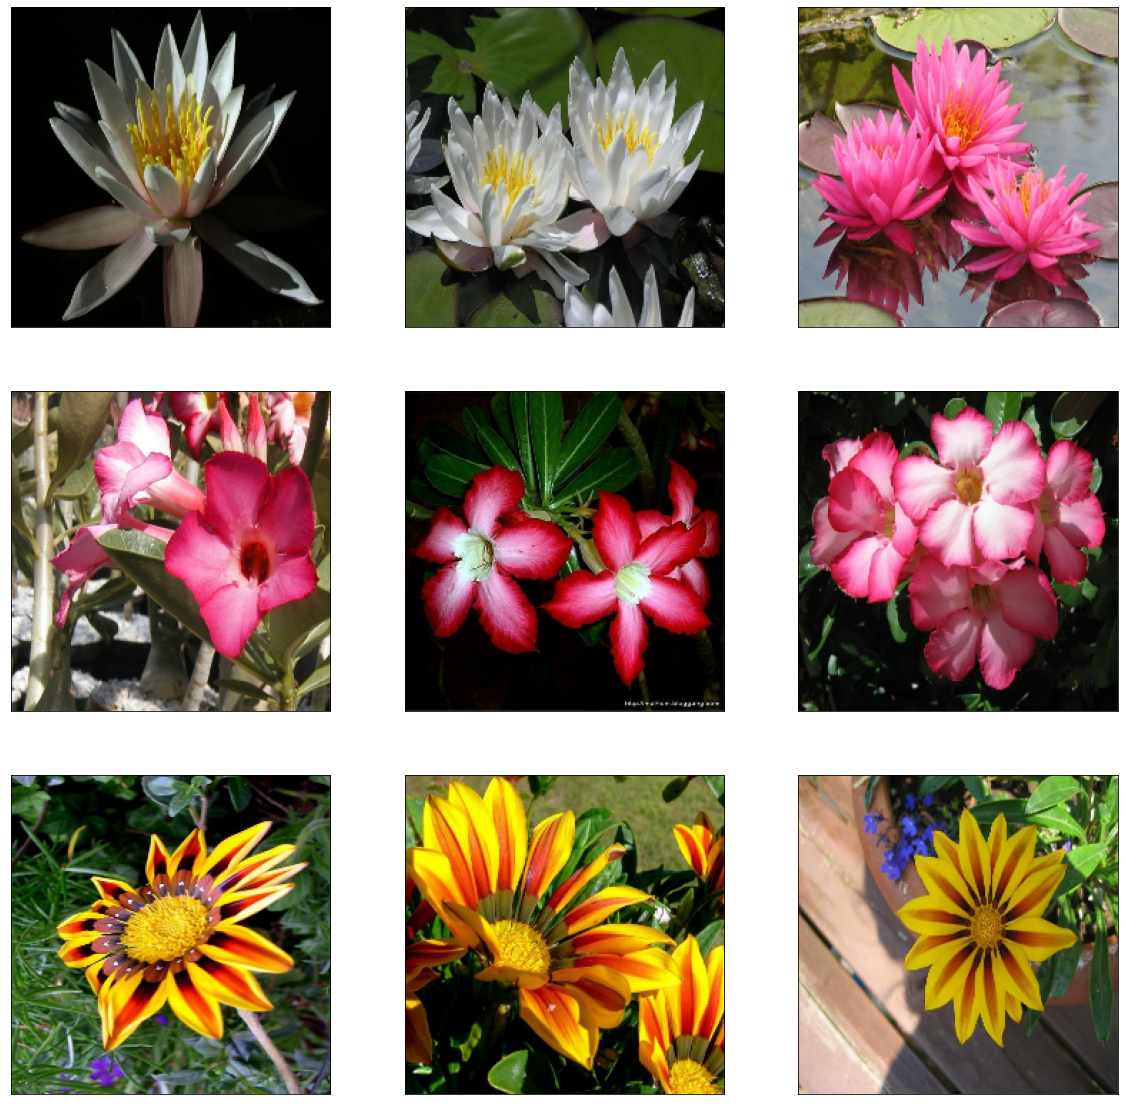

In [ ]:
# ### NOTE THESE ARE DISPLAYED IN GRAYSCALE. Input shape is still (w, h, 3)

_, axarr = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(3):
    for b in range(3):
        temp_image = train_dataset.data[sample_keys[a]][b]
        # temp_image = np.stack((temp_image[:, :, :],) * 3, axis=2)
        # temp_image *= 255
        # temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        # if b == 2:
        #     axarr[a, b].set_title("Class : " + str(sample_keys[a]))
        axarr[a, b].imshow(temp_image)
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)

plt.show()

## Building the Model

Let us construct a Siamese Network.

In [ ]:
# The feature extractor of the best model from the transfer learning experiments.

model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)

In [ ]:
def getSiameseModel(input_shape, batch_size):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(shape=input_shape, batch_size=batch_size)
    right_input = Input(shape=input_shape, batch_size=batch_size)

    # Initialize model
    model = Sequential()
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = module(left_input)
    encoded_r = module(right_input)

    # Add a customized L2 layer to compute the euclidean distance between the encodings
    L2_layer = Lambda(lambda tensors: K.sqrt(K.square(tensors[0] - tensors[1])))
    L2_distance = L2_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid')(L2_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)
    
    # return the model
    return siamese_net

In [ ]:
# (w, h, 3) if rgb
batch_size = 50
input_shape = (train_dataset.w, train_dataset.h, train_dataset.c)
model = getSiameseModel(input_shape, batch_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(50, 224, 224, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(50, 224, 224, 3)]  0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (50, 2048)           23500352    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (50, 2048)           0           ['keras_layer[0][0]',        

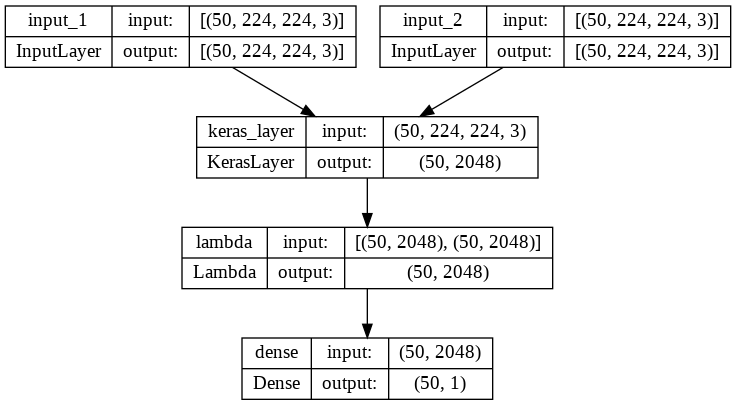

In [ ]:
# rankdir='LR' is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Remember to compile the model!
optimizer = SGD(learning_rate = 0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

## Setting the Model Hyperparameters

To compare with the paper we shall perform Few Shot Learning and validate the model with 100 trials of 5-way classification. Meaning our validation task would have pairs from 5 different classes (and only 1 correct pair).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Remove the directory for every fresh run
!rm -rf weights

# Create a folder for saving the model weights
!mkdir weights

In [ ]:
# Hyperparameters
evaluate_every = 100 # interval for evaluating on one-shot tasks
n_iter = 5000 # No. of training iterations

# batch_size = 50
# Modify batch size while model building!!!

# N_way = N; n_val = k (num trials)
N_way = 5 # how many classes for testing one-shot tasks
n_val = 100 # how many one-shot tasks to validate on

# For saving the best model
best = -1
best_model = -1
model_path = './weights/'

## Training the Network

Let us train the Siamese Network with the above hyperparameters. We are using the SGD optimizer with learning rate 0.0001. Also our batch size is 50.

In [ ]:
print("Starting training process!")
print("-------------------------------------")

val_accs = []
train_loss = []
t_start = time.time()

for i in range(1, n_iter+1):
    inputs, targets = train_dataset.getBatch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    train_loss.append(loss)

    print(f"Iteration {i} of {n_iter}")
    print(f"Train Loss: {loss}") 
    print()

    if i % evaluate_every == 0:
        print("\n -------------------------------------------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        
        # Validating the model every 10 iterations
        val_acc = val_dataset.testOneShot(model, N_way, n_val, verbose=True)
        val_accs.append(val_acc)

        model.save_weights(os.path.join(model_path, "weights.{}.h5".format(i)))

        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc
            best_model = i
            # Noting down the best model

Streaming output truncated to the last 5000 lines.
Iteration 3794 of 5000
Train Loss: 0.40742722153663635

Iteration 3795 of 5000
Train Loss: 0.3566393554210663

Iteration 3796 of 5000
Train Loss: 0.3425062596797943

Iteration 3797 of 5000
Train Loss: 0.41366326808929443

Iteration 3798 of 5000
Train Loss: 0.25383368134498596

Iteration 3799 of 5000
Train Loss: 0.40159928798675537

Iteration 3800 of 5000
Train Loss: 0.4008443057537079


 -------------------------------------------------- 

Time for 3800 iterations: 60.58193499644597 mins
Evaluating model on 100 unique 5 way one-shot learning tasks ...
1/1 [==============================] - 0s 61ms/step
Got an average of 72.0% correct for 5 way one-shot learning accuracy
Iteration 3801 of 5000
Train Loss: 0.33548861742019653

Iteration 3802 of 5000
Train Loss: 0.4557350277900696

Iteration 3803 of 5000
Train Loss: 0.5632601976394653

Iteration 3804 of 5000
Train Loss: 0.3473568856716156

Iteration 3805 of 5000
Train Loss: 0.401439756155

In [ ]:
print(f"Best Validation Accuracy for {N_way} Way One-Shot Learning: {best: .2f}%")
print(f"Best model file: 'weights.{best_model}.h5'")

Best Validation Accuracy for 5 Way One-Shot Learning:  84.00%
Best model file: 'weights.4200.h5'


In [ ]:
# Saving the weights (optional)
!zip -r weights weights.zip

## Visualizing Results

We shall plot the **training loss** and the **validation accuracy** against the number of iterations.

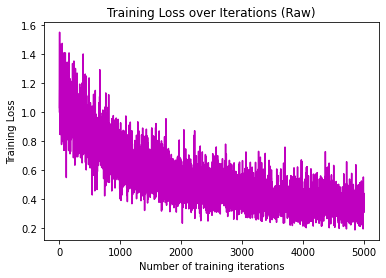

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(train_loss, "m", label="Training Loss")

plt.xlabel("Number of training iterations")
plt.ylabel("Training Loss")
plt.title("Training Loss over Iterations (Raw)")

plt.show()

Hmm, let us run a moving average on the training loss to smooth out the graph.

In [ ]:
# A larger window size would smooth the graph out more. We have picked 250 after playing around a bit.
window_width = 250

cumsum_vec = np.cumsum(np.insert(train_loss, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

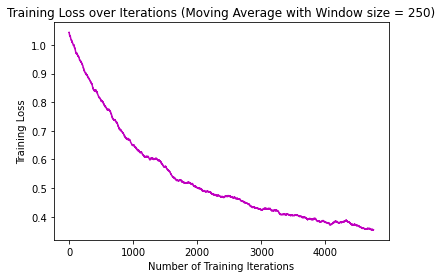

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ma_vec, "m", label="Training Loss (Moving Average)")

plt.xlabel("Number of Training Iterations")
plt.ylabel("Training Loss")
plt.title(f"Training Loss over Iterations (Moving Average with Window size = {window_width})")

plt.show()

In [ ]:
# Need to rerun
val_accs

[24.0,
 21.0,
 30.0,
 28.000000000000004,
 39.0,
 27.0,
 40.0,
 47.0,
 48.0,
 51.0,
 53.0,
 47.0,
 51.0,
 53.0,
 50.0,
 61.0,
 61.0,
 49.0,
 55.00000000000001,
 67.0,
 70.0,
 55.00000000000001,
 67.0,
 66.0,
 62.0,
 66.0,
 72.0,
 71.0,
 67.0,
 66.0,
 68.0,
 71.0,
 73.0,
 80.0,
 73.0,
 78.0,
 71.0,
 72.0,
 77.0,
 79.0,
 73.0,
 84.0,
 79.0,
 72.0,
 80.0,
 67.0,
 83.0,
 76.0,
 71.0,
 80.0]

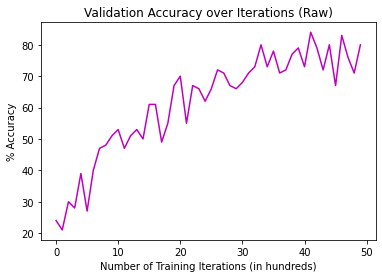

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(val_accs, "m", label="Siamese (val set)")

plt.xlabel("Number of Training Iterations (in hundreds)")
plt.ylabel("% Accuracy")
plt.title("Validation Accuracy over Iterations (Raw)")

plt.show()

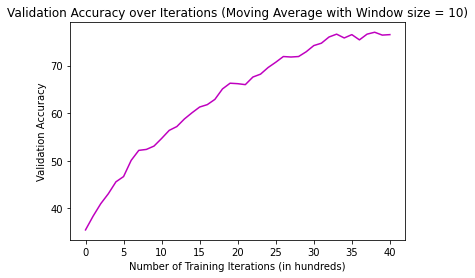

In [ ]:
window_width = 10
cumsum_vec = np.cumsum(np.insert(val_accs, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

fig,ax = plt.subplots(1)
ax.plot(ma_vec, "m", label="Training Loss (Moving Average)")

plt.xlabel("Number of Training Iterations (in hundreds)")
plt.ylabel("Validation Accuracy")
plt.title(f"Validation Accuracy over Iterations (Moving Average with Window size = {window_width})")

plt.show()

## Bonus: Varying the Number of Ways

We shall load the best model weights and evaluate the accuracy of the network as we increase the number of possible classes in the validation task. In other words we are plotting the N-Way Few Shot Learning Accuracy vs N (from 1 to 10).

In [ ]:
model.load_weights(f"./weights/weights.{best_model}.h5")

In [ ]:
ways = np.arange(1, 11, 1)
resume =  False
trials = 100

Evaluating model on 100 unique 1 way one-shot learning tasks ...
1/1 [==============================] - 0s 42ms/step
Got an average of 100.0% correct for 1 way one-shot learning accuracy
Evaluating model on 100 unique 1 way one-shot learning tasks ...
1/1 [==============================] - 0s 41ms/step
Got an average of 100.0% correct for 1 way one-shot learning accuracy
---------------------------------------------------------------------------------------------------------------
Evaluating model on 100 unique 2 way one-shot learning tasks ...
1/1 [==============================] - 0s 43ms/step
Got an average of 94.0% correct for 2 way one-shot learning accuracy
Evaluating model on 100 unique 2 way one-shot learning tasks ...
1/1 [==============================] - 0s 43ms/step
Got an average of 90.0% correct for 2 way one-shot learning accuracy
---------------------------------------------------------------------------------------------------------------
Evaluating model on 100 unique

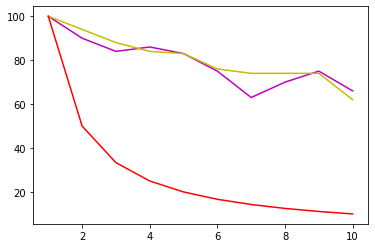

In [ ]:
val_accs, train_accs = [], []
for N in ways:    
    train_accs.append(train_dataset.testOneShot(model, N, trials, verbose=True))
    val_accs.append(val_dataset.testOneShot(model, N, trials, verbose=True))
    print("---------------------------------------------------------------------------------------------------------------")

#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")

# Random Guessing
plt.plot(ways, 100.0/ways,"r")
plt.show()

In [ ]:
print(train_accs)
print(val_accs)

[100.0, 94.0, 88.0, 84.0, 83.0, 76.0, 74.0, 74.0, 74.0, 62.0]
[100.0, 90.0, 84.0, 86.0, 83.0, 75.0, 63.0, 70.0, 75.0, 66.0]


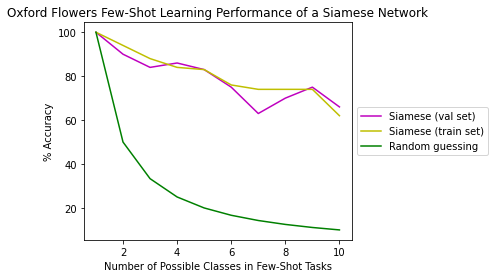

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese (val set)")
ax.plot(ways, train_accs, "y", label="Siamese (train set)")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of Possible Classes in Few-Shot Tasks")
plt.ylabel("% Accuracy")
plt.title("Oxford Flowers Few-Shot Learning Performance of a Siamese Network")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()